# Homework 2

In [70]:
# Import needed packages

import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import scipy
import pickle
import lda
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [2]:
# Read data set

data = pd.read_table("speech_data_extend.txt",encoding="utf-8")
print(data.shape)
data.head()

(23155, 3)


,president,speech,year
0,Washington,Fellow-Citizens of the Senate and House of Rep...,1790
1,Washington,I embrace with great satisfaction the opportun...,1790
2,Washington,In resuming your consultations for the general...,1790
3,Washington,Among the many interesting objects which will ...,1790
4,Washington,"A free people ought not only to be armed, but ...",1790


In [3]:
import topicmodels

In [4]:
data = data[data.year >= 1947]
len(data) # The number of documents (paragraphs of State of the Union Addresses) in the dataset

9488

In [5]:
docsobj = topicmodels.RawDocs(data.speech, "long")

In [6]:
print(data.speech.values[3]) # fourth paragraph (note that Python uses 0-indexing)
print(docsobj.tokens[3])

I come also to welcome you as you take up your duties and to discuss with you the manner in which you and I should fulfill our obligations to the American people during the next 2 years. 
['i', 'come', 'also', 'to', 'welcome', 'you', 'as', 'you', 'take', 'up', 'your', 'duties', 'and', 'to', 'discuss', 'with', 'you', 'the', 'manner', 'in', 'which', 'you', 'and', 'i', 'should', 'fulfill', 'our', 'obligations', 'to', 'the', 'american', 'people', 'during', 'the', 'next', '2', 'years', '.']


In [7]:
docsobj.token_clean(1)

In [8]:
print(docsobj.tokens[3])

['come', 'also', 'to', 'welcome', 'you', 'as', 'you', 'take', 'up', 'your', 'duties', 'and', 'to', 'discuss', 'with', 'you', 'the', 'manner', 'in', 'which', 'you', 'and', 'should', 'fulfill', 'our', 'obligations', 'to', 'the', 'american', 'people', 'during', 'the', 'next', 'years']


In [9]:
docsobj.stopword_remove("tokens")
print(docsobj.tokens[3])

['come', 'welcome', 'duties', 'discuss', 'manner', 'fulfill', 'obligations', 'american', 'people', 'next', 'years']


In [10]:
docsobj.stem()
print(docsobj.stems[3])
docsobj.stopword_remove("stems")

['come', 'welcom', 'duti', 'discuss', 'manner', 'fulfil', 'oblig', 'american', 'peopl', 'next', 'year']


In [11]:
docsobj.term_rank("stems")

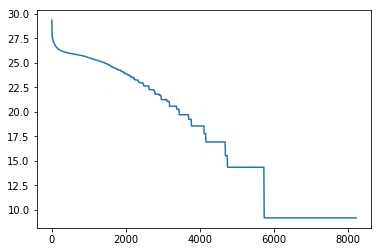

In [12]:
plt.plot([x[1] for x in docsobj.tfidf_ranking])

In [13]:
docsobj.rank_remove("tfidf","stems",docsobj.tfidf_ranking[5000][1])
all_stems = [s for d in docsobj.stems for s in d]
print("number of unique stems = %d" % len(set(all_stems)))
print("number of total stems = %d" % len(all_stems))

number of unique stems = 4742
number of total stems = 250000


In [14]:
len(docsobj.stems)

9488

In [15]:
len(docsobj.stems[0])

8

In [16]:
all_stems = list(set(all_stems))
corp_stems = [stem for doc in docsobj.stems for stem in doc]
all_stems_dict = dict(zip(all_stems,range(len(all_stems))))

In [17]:
Nd = len(corp_stems)

In [18]:
all_stems_dict
D = len(docsobj.stems)

# Uncollapsed Gibbs sampler

In [19]:
def perp(thetas,betas,countsmat,docsobj,all_stems_dict,D,Nd):
    s1 = 0
    ltb = np.log(np.dot(thetas,betas))
    for d in range(D):
        s2 = 0
        #counts = Counter(docsobj.stems[d])
        for v in set(docsobj.stems[d]):
            s2 += ((countsmat[d][v]) * ltb[d,all_stems_dict[v]])
            #s2 += (counts[v] * ltb[d,all_stems_dict[v]])
        s1 += s2
    num = -1 * s1
    den = Nd
    return(np.exp(num/den))

In [20]:
K = 10
D = len(docsobj.stems)
V = len(all_stems)

# Initialise params

eta = 200/V
alpha = 50/K

# Initialise betas and thetas
betas = np.random.dirichlet(alpha = [eta]*V, size = K)
thetas = np.random.dirichlet(alpha = [alpha]*K, size = D)

perplexity = []
countsmat = [Counter(doc) for doc in docsobj.stems]

burnin = 200
# Run iterations
for l in tqdm(range(burnin)):
    den = thetas.dot(betas)
    Z = []
    for d,doc in enumerate(docsobj.stems):
        z_d = [np.argmax(np.random.multinomial(n=1, size=1, pvals=((thetas[d,:].dot(np.diag(betas[:,all_stems_dict[stem]]))/den[d,all_stems_dict[stem]]).tolist()))) for stem in doc]
        Z.append(z_d)
        
    thetas = np.zeros(shape=(D,K))
    N = np.zeros(shape=(D,K))
    for i in range(D):
        counts = Counter(Z[i])
        N[i] = [counts[j] for j in range(K)]
        theta = np.random.dirichlet(alpha=alpha + N[i], size=1)
        thetas[i,:] = theta

    betas = np.zeros(shape=(K,V))
    z_s = [z for doc in Z for z in doc]
    M = np.zeros(shape=(K,V))
    for k in range(K):
        stems = [corp_stems[i] for i in range(Nd) if z_s[i] == k]
        counts = Counter(stems)
        for stem in set(stems):
            M[k,all_stems_dict[stem]] = counts[stem]
        beta = np.random.dirichlet(alpha=eta + M[k], size=1)
        betas[k,:] = beta
    
    if l%20 == 0:
        perplexity.append(perp(thetas,betas,countsmat,docsobj,all_stems_dict,D,Nd))

100%|██████████| 200/200 [15:11<00:00,  4.49s/it]


In [21]:
perplexity

[1336.016028212824,
 1305.4309505367669,
 1285.3356394974182,
 1261.8332868370364,
 1238.6579964637383,
 1212.1753259103232,
 1191.6357751252826,
 1177.903194602289,
 1166.5075571946554,
 1154.1395793416207]

In [22]:
m = 5
n_samples = 100
labels = []
perplexity_pb = [] #perplexity post burn in
for l in tqdm(range(m*n_samples)):
    den = thetas.dot(betas)
    Z = []
    for d,doc in enumerate(docsobj.stems):
        z_d = [np.argmax(np.random.multinomial(n=1, size=1, pvals=((thetas[d,:].dot(np.diag(betas[:,all_stems_dict[stem]]))/den[d,all_stems_dict[stem]]).tolist()))) for stem in doc]
        Z.append(z_d)
        
    thetas = np.zeros(shape=(D,K))
    N = np.zeros(shape=(D,K))
    for i in range(D):
        counts = Counter(Z[i])
        N[i] = [counts[j] for j in range(K)]
        theta = np.random.dirichlet(alpha=alpha + N[i], size=1)
        thetas[i,:] = theta

    betas = np.zeros(shape=(K,V))
    z_s = [z for doc in Z for z in doc]
    M = np.zeros(shape=(K,V))
    for k in range(K):
        stems = [corp_stems[i] for i in range(Nd) if z_s[i] == k]
        counts = Counter(stems)
        for stem in set(stems):
            M[k,all_stems_dict[stem]] = counts[stem]
        beta = np.random.dirichlet(alpha=eta + M[k], size=1)
        betas[k,:] = beta
    
    if l%20 == 0:
        perplexity_pb.append(perp(thetas,betas,countsmat,docsobj,all_stems_dict,D,Nd))
    if l%m == 0:
        #Z_s = [i for sublist in Z for i in sublist]
        #j = np.int(i/m)
        labels.append(Z)

100%|██████████| 500/500 [38:05<00:00,  4.46s/it]


## Exercise 2 - Collapsed Gibbs sampling

In [26]:
#ldaobj = topicmodels.LDA.LDAGibbs(docsobj.stems,10)
#ldaobj.sample(0,5,100)
#perp_coll = ldaobj.perplexity.tolist()

# Done locally and reading from pickle
with open("perp_values.txt", "rb") as fp:   # Unpickling
    perp_coll = pickle.load(fp)

In [27]:
perp_uncoll = perplexity + perplexity_pb

In [29]:
perplexity_pb

[1145.9582550588393,
 1140.0075408208832,
 1136.1620095546934,
 1130.8840733393151,
 1126.1619659429737,
 1125.3222809279741,
 1120.1367240362799,
 1117.5880299992764,
 1115.6602966891207,
 1113.9469299401314,
 1109.8496199670797,
 1109.6886209730935,
 1106.6981598718305,
 1104.5330305359876,
 1103.0905874962293,
 1103.9394173186133,
 1103.8548235656399,
 1102.4366737419161,
 1100.5079732125766,
 1100.1581177628598,
 1099.2055481079776,
 1097.2098259703744,
 1095.9387679518231,
 1094.9546720217372,
 1094.6513861399242]

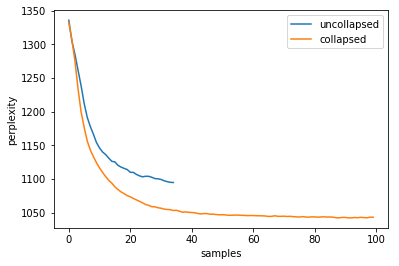

In [28]:
plt.plot(perp_uncoll,label = 'uncollapsed')
plt.plot(perp_coll,label = 'collapsed')
plt.legend()
plt.ylabel('perplexity')
plt.xlabel('samples')
plt.show()

#### We can see that the collapsed sampler stabilizes much faster as compared to the uncollapsed sampler. I take the perplexity every 20 iterations for the uncollapsed sampler

#### Predictive theta and beta

In [ ]:
beta_hat = np.zeros(shape=(K,V))
for i in tqdm(range(K)):
    den = (M[i,:]+eta).sum()
    for j in range(V):
        beta_hat[i,j] = (M[i,j] + eta)/den

In [ ]:
theta_hat = np.zeros(shape=(D,K))
for i in tqdm(range(D)):
    den = (N[i,:]+alpha).sum()
    for j in range(K):
        theta_hat[i,j] = (N[i,j] + alpha)/den

## Question 3

In [31]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
# Create a new variable with only presidents and years
parties = data.loc[:,['president', 'year']]
parties = parties.reset_index()
# Create a new variable with 1 when presidents are Democrats, 0 when they are Republicans
zero_len = pd.Series(np.zeros(len(parties.index)))
parties['parties'] = zero_len
parties['parties'] = (parties.president == "Truman") | (parties.president == "Kennedy") | (parties.president == "Johnson") | (parties.president == "Carter") | (parties.president == "Clinton") | (parties.president == "Obama")
parties.parties = list(map(lambda x: 1 if x else 0, parties.parties))
parties = parties.iloc[:][parties.year >= 1947]
# Set the parties variable as y
y = parties.parties

In [73]:
# Select only documents which appear after 1947 (stored in data)
X = [' '.join(doc) for doc in docsobj.stems]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
vocab = vectorizer.get_feature_names()

# Split the X and y variables into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size = 0.3, random_state = 42)

# Create the logistic regression estimator with an l1 loss parameter
log_reg = LogisticRegressionCV(penalty = "l1", solver="liblinear")

# Fit the model, predict and report the accuracy and the best parameter
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Accuracy: {}".format(log_reg.score(X_test, y_test)))

print(classification_report(y_test, y_pred))

print("Tuned Model Parameters: {}".format(log_reg.C_))

auc = roc_auc_score(y_test, log_reg.decision_function(X_test))
print('AUC score when using document-term matrix: {}'.format(auc))

## Run a logistic regression using the topics instead of the document-term matrix
X = [' '.join(doc) for doc in docsobj.stems]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

K, S, alpha, eta = 10, 1000, 0.1, 0.01

Col_Gibbs = lda.LDA(n_topics=K, n_iter=S, alpha=alpha, eta=eta)

X = Col_Gibbs.fit_transform(X)

# Split the X and y variables into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 59)

# Create the logistic regression estimator
log_reg = LogisticRegressionCV(penalty="l2", solver="newton-cg")

# Fit the model, predict and report the accuracy and the best parameter
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Accuracy: {}".format(log_reg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(log_reg.C_))

auc = roc_auc_score(y_test, log_reg.decision_function(X_test))
print('AUC score when using topics: {}'.format(auc))

Accuracy: 0.6761503336845802
             precision    recall  f1-score   support

          0       0.66      0.74      0.70      1444
          1       0.69      0.61      0.65      1403

avg / total       0.68      0.68      0.67      2847

Tuned Model Parameters: [ 0.35938137]
AUC score when using document-term matrix: 0.7399974431520899


INFO:lda:n_documents: 9488
INFO:lda:vocab_size: 4742
INFO:lda:n_words: 250000
INFO:lda:n_topics: 10
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -2661826
INFO:lda:<10> log likelihood: -2077618
INFO:lda:<20> log likelihood: -1987666
INFO:lda:<30> log likelihood: -1953114
INFO:lda:<40> log likelihood: -1931842
INFO:lda:<50> log likelihood: -1921545
INFO:lda:<60> log likelihood: -1915514
INFO:lda:<70> log likelihood: -1910984
INFO:lda:<80> log likelihood: -1906653
INFO:lda:<90> log likelihood: -1904568
INFO:lda:<100> log likelihood: -1903775
INFO:lda:<110> log likelihood: -1901340
INFO:lda:<120> log likelihood: -1900211
INFO:lda:<130> log likelihood: -1900286
INFO:lda:<140> log likelihood: -1898358
INFO:lda:<150> log likelihood: -1899064
INFO:lda:<160> log likelihood: -1898420
INFO:lda:<170> log likelihood: -1898299
INFO:lda:<180> log likelihood: -1898357
INFO:lda:<190> log likelihood: -1896960
INFO:lda:<200> log likelihood: -1896936
INFO:lda:<210> log likelihood: -1896832
INFO:lda:

Accuracy: 0.580962416578855
             precision    recall  f1-score   support

          0       0.59      0.65      0.62      1480
          1       0.57      0.50      0.54      1367

avg / total       0.58      0.58      0.58      2847

Tuned Model Parameters: [ 0.35938137]
AUC score when using topics: 0.604546847505882


# We can see from the AUC scores that using document-term matrix is better for prediction as compared to using the topics from LDA